In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giordanogaudio","key":"919ae4f93b04aab1c95da61f351fb042"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rounakbanik/pokemon
! unzip pokemon.zip

  0% 0.00/46.6k [00:00<?, ?B/s]
100% 46.6k/46.6k [00:00<00:00, 27.1MB/s]
Archive:  pokemon.zip
  inflating: pokemon.csv             


`pokemon.csv` is a dataset of all images of every pokemon from this[ dataset ](https://www.kaggle.com/datasets/rounakbanik/pokemon). Lets read this into a dataframe with pandas.

In [ ]:
import pandas as pd

pokemon = pd.read_csv("pokemon.csv")

# What kind of data are we working with?

for col in pokemon.columns:
    print(col)

abilities
against_bug
against_dark
against_dragon
against_electric
against_fairy
against_fight
against_fire
against_flying
against_ghost
against_grass
against_ground
against_ice
against_normal
against_poison
against_psychic
against_rock
against_steel
against_water
attack
base_egg_steps
base_happiness
base_total
capture_rate
classfication
defense
experience_growth
height_m
hp
japanese_name
name
percentage_male
pokedex_number
sp_attack
sp_defense
speed
type1
type2
weight_kg
generation
is_legendary


There are alot of column names here, not all of which are necessary. The critical bits of information are: `name, type1, type2, generation, is_legendary`. We don't need the pokedex number as it is `1 + index`. These categories may be useful for analysis.

In [ ]:
pokemon = pokemon[['pokedex_number','name', 'type1', 'type2', 'generation', 'is_legendary']]
pokemon

# Now the data looks a little cleaner

,pokedex_number,name,type1,type2,generation,is_legendary
0,1,Bulbasaur,grass,poison,1,0
1,2,Ivysaur,grass,poison,1,0
2,3,Venusaur,grass,poison,1,0
3,4,Charmander,fire,NaN,1,0
4,5,Charmeleon,fire,NaN,1,0
...,...,...,...,...,...,...
796,797,Celesteela,steel,flying,7,1
797,798,Kartana,grass,steel,7,1
798,799,Guzzlord,dark,dragon,7,1
799,800,Necrozma,psychic,NaN,7,1


Next we can go into the pokemon images [dataset](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset).

In [ ]:
! kaggle datasets download -d kvpratama/pokemon-images-dataset
! unzip pokemon-images-dataset

Now there are a couple problems in combining the images dataset with the info dataset. 
* the largest pokedex number in the images dataset is 721 whereas in the other dataset it is 801. This is easy enough, we simply ignore all pokemon in the info dataset after 721.

* some pokemon have a male and female image (the female one is usually indicated with `"f"` or `"-f"`, and the male one has no markers). This is mostly okay, we can simply ignore any images with a name that contains an `"f"`.

* some pokemon have different 'forms' (indicated with a `"-<form>"`. Here are two examples; Gengar and Rotom

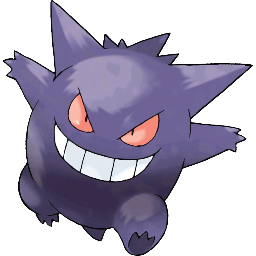

Gengar


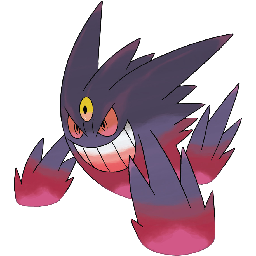

Mega Gengar


In [ ]:
from IPython.display import Image, display
display(Image('/content/pokemon/pokemon/94.png'))
print("Gengar")
display(Image('/content/pokemon/pokemon/94-mega.png'))
print("Mega Gengar")

Possibly the worst offender is pokemon number 479 Rotom who has 6 forms


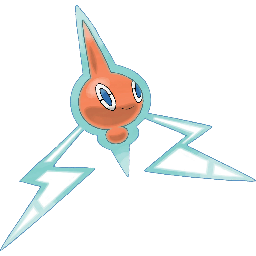

Rotom


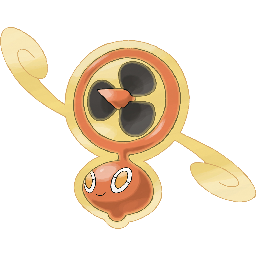

Fan Rotom


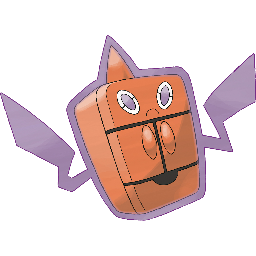

Frost Rotom


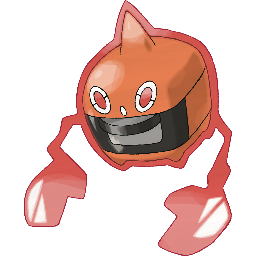

Heat Rotom


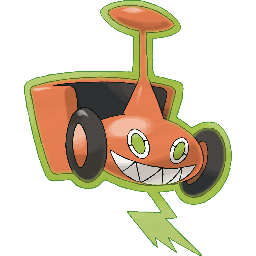

Mow Rotom


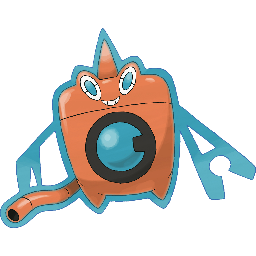

Wash Rotom


In [ ]:
display(Image('/content/pokemon/pokemon/479.png'))
print("Rotom")
display(Image('/content/pokemon/pokemon/479-fan.png'))
print("Fan Rotom")
display(Image('/content/pokemon/pokemon/479-frost.png'))
print("Frost Rotom")
display(Image('/content/pokemon/pokemon/479-heat.png'))
print("Heat Rotom")
display(Image('/content/pokemon/pokemon/479-mow.png'))
print("Mow Rotom")
display(Image('/content/pokemon/pokemon/479-wash.png'))
print("Wash Rotom")

We can take care of both forms and gender by removing any files containing a hyphen.

In [ ]:
import os

image_path = "/content/pokemon/pokemon"

unique_pokemon_images = []
unique_pokemon_image_names = []

counter = 0

for filename in os.listdir(image_path):
    if not("-" in filename or "f" in filename):
      unique_pokemon_image_names.append(filename)
      unique_pokemon_images.append(int(filename.split(".")[0]))


But this is actually overkill because as we can see bellow: we now are missing some pokemon

In [ ]:
missing_pokemon_images = []

for i in range(1, 720):
  if i not in unique_pokemon_images:
    missing_pokemon_images.append(i)

missing_pokemon_images

[201,
 386,
 412,
 413,
 421,
 422,
 423,
 487,
 492,
 493,
 550,
 555,
 585,
 586,
 641,
 642,
 645,
 647]

So what's the cause of this, lets inspect each of these missing cases and see what is happening

pokemon # 201 is only female

all of the other numbers are only available in forms. Take for example pokemon # 492, Shaymin, which appears only in a "land" and "sky" form

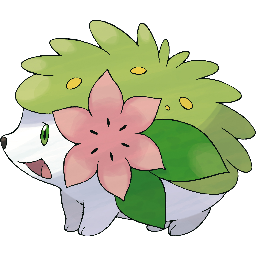

Land Shaymin


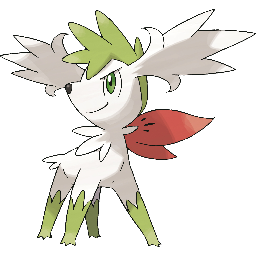

Sky Shaymin


In [ ]:
display(Image('/content/pokemon/pokemon/492-land.png'))
print("Land Shaymin")
display(Image('/content/pokemon/pokemon/492-sky.png'))
print("Sky Shaymin")

Fixing # 201 is easy enough, the male and female versions of unknown look identical so we can simply drop the female marker.

Fixing the remaining missing pokemon presents us with a number of possible problems. For some of these pokemon, we will need to either:

A) Copy rows to the info dataframe corresponding to the different forms

B) Pick one of the forms at random, and use that form as a representative for that pokemon.

I will opt for the second option.

We can create a new folder with the `unique_pokemon_images` and manually add the `missing_pokemon_images`.

In [ ]:
! mkdir images

import shutil

image_path = image_path + "/"
destination = "/content/images"
destination_path = destination + "/"



for filename in unique_pokemon_image_names:
  shutil.copy(image_path  + filename, destination)


#manually copying (and renaming) the missing pokemon

def copy_rename(old_number_list, number_list):
  for i in range(len(old_number_list)):
    shutil.copy(image_path + old_number_list[i] + ".png", destination)
    os.rename(destination_path + old_number_list[i] + ".png", 
              destination_path + str(number_list[i]) + ".png")
  return

chosen_representatives = ["201-f", "386-attack", "412-plant", "413-plant", 
                          "421-sunshine", "422-east", "423-west", "487-altered",
                          "492-land", "493-normal", "550-red-striped",
                          "555-standard", "585-autumn", "586-winter", "641-incarnate",
                          "642-therian", "645-therian", "647-ordinary"]



copy_rename(chosen_representatives, missing_pokemon_images)


The last thing we need to do the make sure we have consistent data is to cut the info dataset after pokemon number 721 (index 720). To make sure we did this right we can display the name and image of pokemon number 721 to make sure they lign up.

In [ ]:
pokemon = pokemon[0:721]

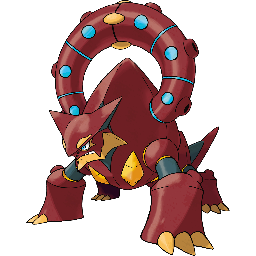

Volcanion


In [ ]:
display(Image('/content/images/721.png'))
print(pokemon.name[720])

This might be a subjective take, but that certainly looks like a Volcanion. Now lets download the data and images in a useable form

In [ ]:
! mkdir pokemon_info

pokemon.to_csv('/content/pokemon_info/pokemon_data.csv', sep = ',')

In [ ]:
# download data
files.download('/content/pokemon_info/pokemon_data.csv')

In [ ]:
! zip -r /content/images.zip /content/images/

In [ ]:
files.download('/content/images.zip')

Next I'll do some analysis to see what is happening to our data from generation to generation.